### Libraries

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import itertools
import random

### Thoughts on Strategy Employed
<ol>
    <li>The problem requires prediction for a number of days for every store-item pair in the test dataset. Any model developed will be evaluated on the quality of its predictions. Symmetric Mean Absolute Percentage Error (SMAPE) is the metric to use for the evaluation.
    <li>There are, in effect, 500 different timeseries in the train (and test) dataset - one for each store-item pair and predictions need to be made for each of these timeseries. There are 4 possible strategies, <i>in decreasing order of computing power required</i>, to build models and make predictions:
        <ul>
            <li>Build 500 different models, one for each for the store-item pair and then use a model to make predictions for the corresponding series in the test dataset.
            <li>Build 50 different models, one for each item. In this strategy, a model for a item is built by aggregating the daily sales for all stores. Then use every model to make predictions for the corresponding 10 timeseries for the respective item in the test dataset.
            <li>Build 10 different models, one for each store. In this strategy, a model for a store is built by aggregating the daily sales for all items. Then use every model to make predictions for the corresponding 50 timeseries for the respective store in the test dataset. In other words, we build a separate model for each store but apply the same model to all the 50 item series of a store.
            <li>Build a single model. In this strategy, a model is built by aggregating the daily sales for all items across all stores. Then use the model to make predictions for the 500 timeseries in the test dataset.
        </ul>
    <li>We divide the train dataset into to subsets - train and validation. The train subset will be used to build the required models, where as the validation subset will be used to compare the results across the differnt strategies. We divide the train dataset in the ratio 90:10.
    <li>To keep the computing effort manageable, 2 out of the 10 strores and 5 of the 50 items will be randomly chosen, yielding 10 store-item pair combinations. Models under strategies 1 and 2 above will be built only for the relevant store-item pairs or items and predictions under all strategies will be made for only these 10 timeseries. Average SMAPE value across the 10 timeseries will be used to compare the efficacy of the 4 proposed strategies.
</ol>    

### Get Data

In [44]:
train = pd.read_csv('./data/train.csv')

# Typecasting data
train.date = pd.to_datetime(train.date, format = '%Y-%m-%d')     
train.store = train.store.astype('category')
train.item = train.item.astype('category')

# New Timeseries that is the aggregate of the sales for all products and all items

ts = train.groupby('date')['sales'].sum()
'''ts_orig = ts.copy()
ts = np.log(ts)'''
ts.index = pd.DatetimeIndex(ts.index.values, freq = 'D')
display(ts.head())

2013-01-01    13696
2013-01-02    13678
2013-01-03    14488
2013-01-04    15677
2013-01-05    16237
Freq: D, Name: sales, dtype: int64

#### Create Train, Validation and Test Sets

<ol>
    <li>We divide the timeseries into two parts, 70% train subset, 15% validation subset and 15% test subset.
</ol>

In [70]:
train_idx = np.int(0.7*len(ts))
val_idx = np.int(0.85*len(ts))

#### Set up the Configuration Grid Search

In [71]:
# Configuration options for the model()
trend = ['add', 'mul', None]
damped = [True, False]
seasonal = ['add', 'mul', None]
seasonal_periods = [7]

# Configuration options for model.fit()
smoothing_level = [0.2, 0.4, 0.6, 0.8, 1.0]
smoothing_slope = [0.2, 0.4, 0.6, 0.8, 1.0]
smoothing_seasonal = [0.2, 0.4, 0.6, 0.8, 1.0]
damping_slope = [0.2, 0.4, 0.6, 0.8, 1.0]
box_cox = [True, False]
remove_bias = [True, False]

<ol>
    <li>For each possible model config, we create a Holt-Winters model for the train subset.
    <li>For each Holt-Winters model, we fit the model to the train subset using each of the fit configs.
    <li>For each of the fitted models, we predict the likely sales values for the validation set and then calcualte the SMAPE score for the predictions.
    <li>We are looking for the model with the lowest SMAPE score
</ol>        

In [72]:
model_configs = itertools.product(trend, damped, seasonal, seasonal_periods)
fit_configs = itertools.product(smoothing_level, smoothing_slope, smoothing_seasonal, damping_slope, 
                                box_cox, remove_bias)
best_smape = 100
for m_config in model_configs:
    t, d, s, s_p = m_config  
    try:
        history = np.array(ts[:train_idx])
        model = ExponentialSmoothing(history, trend = t, damped = d, seasonal = s, 
                                     seasonal_periods = s_p)
        for f_config in fit_configs:
            sl, ss, s_s, d_s, b, r = f_config
            try:
                fit = model.fit(smoothing_level = sl, smoothing_slope = ss, smoothing_seasonal = s_s, 
                                damping_slope = d_s, optimized = False, use_boxcox = b, remove_bias = r)
                preds = fit.predict(train_idx, val_idx-1)
                #preds = np.exp(preds)
                acts = ts[train_idx:val_idx]
                smape = np.mean(abs(acts - preds)/(abs(acts) + abs(preds)))*100
                if smape < best_smape:
                    best_smape = smape
                    best_m_config = m_config
                    best_f_config = f_config
            except:
                print("Failed to fit a model for config {}".format(f_config))
    except:
        print("Failed to build a model for config {}".format(m_config))
        continue

t, d, s, s_p = best_m_config
sl, ss, s_s, d_s, b, r = best_f_config

print("The lowest SMAPE score achieved for the validation set = %.4f" % best_smape)
print("The parameters for the model with best SMAPE:")
print("trend = %s, damped = %s, seasonal = %s, seasonal_periods = %i" % best_m_config)
print("smoothing_level = %.2f, smoothing_slope = %.2f, smoothing_seasonal = %.2f, damping_slope = %s, box_cox_transformation = %s, remove_bias = %s" 
      % best_f_config)

Failed to build a model for config (None, True, 'add', 7)
Failed to build a model for config (None, True, 'mul', 7)
Failed to build a model for config (None, True, None, 7)
The lowest SMAPE score achieved for the validation set = 5.2103
The parameters for the model with best SMAPE:
trend = add, damped = True, seasonal = add, seasonal_periods = 7
smoothing_level = 0.20, smoothing_slope = 0.80, smoothing_seasonal = 0.80, damping_slope = 1.0, box_cox_transformation = True, remove_bias = False


#### Observations
We look to get a more fine grained estimate of the <i>fit configuration</i> parameters by searching in a range close to the ideal values identified in the earlier step.

In [73]:
# Configuration options for the model()
trend = ['add']
damped = [True]
seasonal = ['add']
seasonal_periods = [7]

# Configuration options for model.fit()
smoothing_level = [0.1, 0.15, 0.2, 0.25, 0.3]
smoothing_slope = [0.7, 0.75, 0.8, 0.85, 0.9]
smoothing_seasonal = [0.7, 0.75, 0.8, 0.85, 0.9]
damping_slope = [0.9, 0.95, 1]
box_cox = [True]
remove_bias = [False]

In [74]:
model_configs = itertools.product(trend, damped, seasonal, seasonal_periods)
fit_configs = itertools.product(smoothing_level, smoothing_slope, smoothing_seasonal, damping_slope, 
                                box_cox, remove_bias)
best_smape = 100
for m_config in model_configs:
    t, d, s, s_p = m_config  
    try:
        history = np.array(ts[:train_idx])
        model = ExponentialSmoothing(history, trend = t, damped = d, seasonal = s, 
                                     seasonal_periods = s_p)
        for f_config in fit_configs:
            sl, ss, s_s, d_s, b, r = f_config
            try:
                fit = model.fit(smoothing_level = sl, smoothing_slope = ss, smoothing_seasonal = s_s, 
                                damping_slope = d_s, optimized = False, use_boxcox = b, remove_bias = r)
                preds = fit.predict(train_idx, val_idx-1)
                acts = ts[train_idx:val_idx]
                smape = np.mean(abs(acts - preds)/(abs(acts) + abs(preds)))*100
                if smape < best_smape:
                    best_smape = smape
                    best_m_config = m_config
                    best_f_config = f_config
            except:
                print("Failed to fit a model for config {}".format(f_config))
    except:
        print("Failed to build a model for config {}".format(m_config))
        continue

t, d, s, s_p = best_m_config
sl, ss, s_s, d_s, b, r = best_f_config

print("The lowest SMAPE score achieved for the validation set = %.4f" % best_smape)
print("The parameters for the model with best SMAPE:")
print("trend = %s, damped = %s, seasonal = %s, seasonal_periods = %i" % best_m_config)
print("smoothing_level = %.2f, smoothing_slope = %.2f, smoothing_seasonal = %.2f, damping_slope = %s, box_cox_transformation = %s, remove_bias = %s" 
      % best_f_config)

The lowest SMAPE score achieved for the validation set = 5.2103
The parameters for the model with best SMAPE:
trend = add, damped = True, seasonal = add, seasonal_periods = 7
smoothing_level = 0.20, smoothing_slope = 0.80, smoothing_seasonal = 0.80, damping_slope = 1, box_cox_transformation = True, remove_bias = False


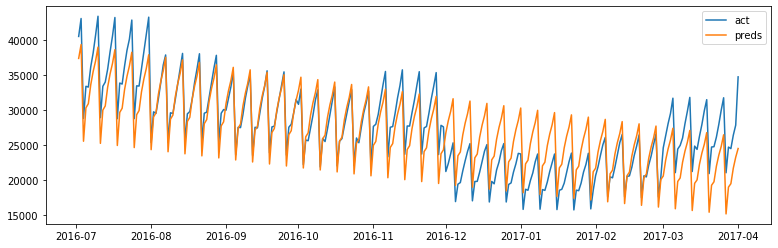

In [75]:
history = np.array(ts[:train_idx])

model = ExponentialSmoothing(history, trend = 'add', damped = True, seasonal = 'add', seasonal_periods = 7)
fit = model.fit(smoothing_level = 0.2, smoothing_slope = 0.8, smoothing_seasonal = 0.8, damping_slope = 1, 
                optimized = False, use_boxcox = True, remove_bias = False)
preds = fit.predict(train_idx, val_idx-1)
acts = ts[train_idx:val_idx]

plt.figure(figsize = (13, 4))
plt.plot(ts.index[train_idx:val_idx], acts, label = 'act')
plt.plot(ts.index[train_idx:val_idx], preds, label = 'preds')
plt.legend()
plt.show()

#### Observations
We have a good set of cross validated parameter values. We use these to build a new model that includes both the train and validation subsets and use the resulting model to estimate the likely test set error using the test subset. 

In [76]:
history = np.array(ts[:val_idx])

model = ExponentialSmoothing(history, trend = 'add', damped = True, seasonal = 'add', seasonal_periods = 7)
fit = model.fit(smoothing_level = 0.2, smoothing_slope = 0.8, smoothing_seasonal = 0.8, damping_slope = 1, 
                optimized = False, use_boxcox = True, remove_bias = False)
preds = fit.predict(val_idx, len(ts)-1)
acts = ts[val_idx:]
smape = np.mean(abs(acts - preds)/(abs(acts) + abs(preds)))*100

print("The estimated test set SMAPE = %.4f" % smape)

The estimated test set SMAPE = 52.2841


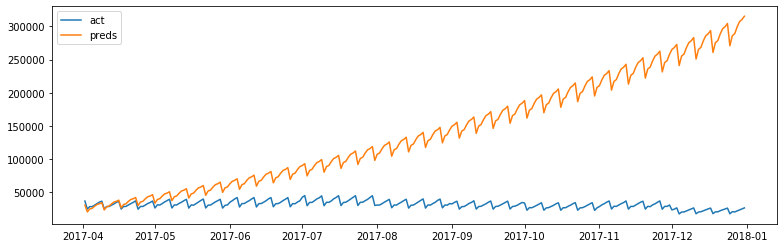

In [77]:
plt.figure(figsize = (13, 4))
plt.plot(ts.index[val_idx:], acts, label = 'act')
plt.plot(ts.index[val_idx:], preds, label = 'preds')
plt.legend()
plt.show()